<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/Prime_modifiche/Copy_of_Lecture11_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Reading the images

In [39]:
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
import os
import glob
import numpy as np

import logging
import time

#logger = logging.getLogger(__name__)
#logger.setLevel(logging.DEBUG)

logging.basicConfig(level=logging.INFO)

In [40]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'
#PATH = 'gdrive/MyDrive/Immagini'

*  Imread restituisce un array 60 x 60

In [41]:
def read_imgs(dataset_path, classes):
  tmp = []
  labels = []
  for cls in classes:
    fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.pgm'))
    tmp += [ imread(fname) for fname in fnames ]
    labels += len(fnames)*[cls]
  return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)

Ci sta ~5 minuti a caricare le immagini

In [45]:
initial_time = time.time()
path_to_png_data = os.path.join(PATH, 'Train')
x_train, y_train = read_imgs(path_to_png_data, [0, 1])

test_dataset_path =os.path.join(PATH, 'Test')
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

elapsed_time=time.time() - initial_time
logging.info('Done in %.2f minutes',elapsed_time/60)


INFO:root:Done in 0.02 minutes


(396, 60, 60, 1) (396,)
(401, 60, 60, 1) (401,)


In [43]:
len(x_train)

396

In [ ]:
'''
Questa parte serve solo per visualizzare qualche immagine dalla #a alla #a+3
'''

image_type = 'Test/1'
a=6
i=0
plt.figure(i)

for imagename in (os.listdir(os.path.join(PATH, image_type)))[a:a+4]:
  Im = imread(os.path.join(PATH, image_type, imagename))
  print(Im.shape)
 #plt.subplot(2, 2, i)
  plt.figure(i)
  imshow(Im)
  i+=1

# Defining a CNN model

In [46]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential

##CNN prova
Per ora è la miglire tra le 3 (con 100 epoche) per loss e validation sul dataset augmented

In [47]:
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(50, (5,5), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(60, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
        
      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(100, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(50, (4,4), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D(2, 2),

      Flatten(), 
      

      Dense(1, activation='sigmoid')
      
  ])
  
  return model


## CNN presa da https://www.researchgate.net/publication/332306208_Convolutional_Neural_Networks_for_the_Segmentation_of_Microcalcification_in_Mammography_Imaging (con sigmoide al posto di SoftMax)




In [ ]:
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(16, (3,3), padding='same', input_shape=shape),
      Activation('relu'),
      MaxPool2D((2,2)),
      BatchNormalization(),
      
      Conv2D(32, (3,3), padding='same'),
      Activation('relu'),
      MaxPool2D((2,2)),
      BatchNormalization(),
        
      Conv2D(16, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(16, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(16, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(32, (3, 3), padding= 'same'),
      BatchNormalization(),
      Activation('relu'),

      Flatten(), 
      
      Dense(64, activation = 'relu'),
      BatchNormalization(),
      Dense(1, activation='sigmoid')
      
  ])
  
  return model

##CNN presa da https://www.hindawi.com/journals/cmmm/2019/2717454/
Layers {96, 256, 384, 384, 256} with a kernel size of {11, 5, 3, 3, 4}, 

In [ ]:
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(96, (11,11), padding='same', input_shape=shape),
      Activation('relu'),
      MaxPool2D((2,2)),
      BatchNormalization(),
      
      Conv2D(256, 5, padding='same'),
      Activation('relu'),
      MaxPool2D((2,2)),
      BatchNormalization(),
        
      Conv2D(384, 3, padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(384, 3, padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(256, 4, padding='same'),
      BatchNormalization(),
      Activation('relu'),


      Flatten(), 
      
      Dropout(0.5),
      Dense(1, activation='sigmoid')
      
  ])
  
  return model

## MODEL = MAKE_MODEL() AND COMPILE

In [48]:
from keras.optimizers import SGD

model = make_model()

model.compile(optimizer=SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')


#Fit model on Dataset

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5,
    patience = 5,
    min_lr=0.00001

)

checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


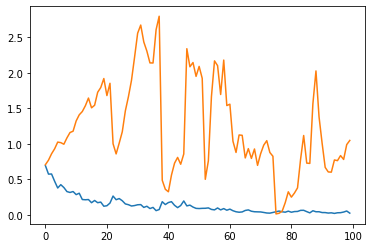

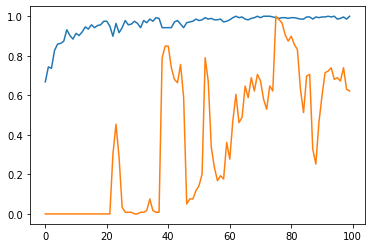

In [ ]:
history = model.fit(x_train, y_train, 
                    validation_split=0.3, 
                    epochs=100, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=0)



#print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
model.save(os.path.join(PATH, 'model.hdf5'))
model.evaluate(x_test, y_test)  # returns 'loss' and 'metrics' (accuracy)

13/13 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.7332


[0.711947500705719, 0.7331671118736267]

# Data augmentation
 Before we can run data aumentation with ImageDataGenerator we need to convert the PGM format to PNG

In [ ]:
basename = os.path.basename(PATH)
print(basename)

Mammography_micro


In [ ]:
import PIL
import os

In [ ]:
def convert_to_png(fname, dest_folder):
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  dest_fname = os.path.join(dest_folder, dest_fname)
  PIL.Image.open(fname).convert('L').save(dest_fname)


Provare a fare una funzione migliore per convertire tutti i pgm in png
Questa ci sta ~5 minuti

In [ ]:
start_time = time.time()
for data_path in [os.path.join(PATH, "Train"), os.path.join(PATH, "Test")]:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)
print('Elapsed time = %.2f s', time.time()-start_time)

291.19284987449646


# Data aumentation

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Il FLOW_FROM_DIRECTORY prende in input il path della directory di arrivo e genera gruppi di immagini dando in output un ITERATORE (x, y) con y le labels e x le immagini con shape (batch_size, *target_size, channels)

di default crea le imm in png

*  batch_size (di default è 32) cioè il numero di immagini modificate generate per ogni immagine di X_train.

*  subset = training o validation, funziona solo se c'è validation_split nel 




ImageDataGenerator


IMAGEDATAGENERATOR:
Validation_split = 0.3 divide tutte le N immagini di x_train in: 70% train e 30% validazione e usa questo dataset nel model.fit 



In [ ]:
path_to_png_data = os.path.join(PATH, "Train_png")

img_width, img_height = (60, 60)

aug_validation_split = 0.3


train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2, #shear deforma l'immagine "tirandola tra due lati"
        zoom_range=0.2, 
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split = aug_validation_split)  
        



train_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')



Found 278 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


Il.next() accede ad una immagine. train_gen.next()[0] ha shape = (32, 60, 60, 1) cioè per ogni immagine del dataset, lui genera 32 immagini modificate di dimensione 60x60 di colori grayscale

# Fit model on augmented images

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

STEPS_PER_EPOCH: Definisce il numero di immagini da usare ad ogni epoca, è utile quando il numero delle immagini non è fisso perchè vengono generate potenzialmente infiniti samples

In [ ]:
Tot_train_imgs = len(x_train)

In [ ]:
model = make_model()


model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


batch_size=32
steps_per_epoch = int(Tot_train_imgs * (1- aug_validation_split))
validation_steps = int(Tot_train_imgs * aug_validation_split)

history = model.fit(
        train_gen,
        steps_per_epoch=278 // batch_size,
        epochs=100,
        validation_data=val_gen,
        validation_steps= 118 // batch_size,
        verbose=1,
        callbacks=[checkpoint])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Saving the model

In [ ]:
model.save(os.path.join(PATH, 'model_augmented.hdf5'))

model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 5ms/step - loss: 0.3028 - accuracy: 0.9152


[0.3028273582458496, 0.9152119755744934]

# Comparing the performances of the two models

In [ ]:
from keras.models import load_model
aug_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))
noaug_model = load_model(os.path.join(PATH, 'model.hdf5'))

In [ ]:
noaug_model.evaluate(x_test, y_test)

aug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 15ms/step - loss: 0.6845 - accuracy: 0.5686


[0.684547483921051, 0.5685785412788391]

#Implement a cross-validation test

In [49]:
from sklearn.model_selection import KFold

In [ ]:
# Define per-fold score arrays
acc_per_fold = []
loss_per_fold = []

# Merge train and test in a single array
X_tot = np.concatenate((x_train, x_test), axis=0)
Y_tot = np.concatenate((y_train, y_test), axis=0)


num_folds = 10

kfold = KFold(n_splits=num_folds, shuffle=True)

batch_size = 32
num_epochs = 30

for train, test in kfold.split(inputs, targets):
  fold_nro = 1
  print('In fold n. ', fold_nro)
  model = make_model()

  model.compile(optimizer=SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')

  history = model.fit(
          X_tot[train], Y_tot[train],
          batch_size = batch_size,
          verbose=0,
          epochs = num_epochs)  
  
  scores = model.evaluate(X_tot[test], Y_tot[test], verbose=0)

  print(f'Score for fold {fold_nro}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold_nro += 1

Computing average scores

In [51]:
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

print('\n')
print('Average scores for all folds:')
print(f'-- Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'-- Loss: {np.mean(loss_per_fold)}')



Score per fold
> Fold 1 - Loss: 0.18454262614250183 - Accuracy: 92.5000011920929%
> Fold 2 - Loss: 0.33404821157455444 - Accuracy: 87.5%
> Fold 3 - Loss: 0.2539677023887634 - Accuracy: 88.7499988079071%
> Fold 4 - Loss: 0.23129165172576904 - Accuracy: 91.25000238418579%
> Fold 5 - Loss: 0.16628272831439972 - Accuracy: 94.9999988079071%
> Fold 6 - Loss: 0.3571431636810303 - Accuracy: 88.7499988079071%
> Fold 7 - Loss: 0.2507432699203491 - Accuracy: 88.7499988079071%
> Fold 8 - Loss: 0.21372686326503754 - Accuracy: 91.13923907279968%
> Fold 9 - Loss: 0.7303618788719177 - Accuracy: 88.60759735107422%
> Fold 10 - Loss: 0.16900086402893066 - Accuracy: 88.60759735107422%


Average scores for all folds:
-- Accuracy: 90.08544325828552 (+- 2.2102587942435514)
-- Loss: 0.2891108959913254
